# File Import

Scraping Wikipedia articles and reading metadata is possible, but it becomes inefficient due to the difficulties that arise if too many users try to do this on too many pages at the same time. 
Mediawiki allows access to current and historical information on the one hand via the API and on the other hand via so-called backup dumps, where the complete Wikipedia articles of certain data are made available for download in compressed form: https://dumps.wikimedia.org/enwiki/

For this project, the dumps from 1 February 2022 were used. The code available on the following page and adapted to our needs was used as the basis for the data import: https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/notebooks/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb

Packages used:
  
**requests:** https://docs.python-requests.org/en/latest/  
**BeautifulSoup:** https://www.crummy.com/software/BeautifulSoup/  
**keras:** https://keras.io/  
**segmentation_models:** https://github.com/qubvel/segmentation_models  
**tensorflow:** https://www.tensorflow.org/  
**pandas:** https://pandas.pydata.org/  
**matplotlib:** https://matplotlib.org/  


In [12]:
import requests
from bs4 import BeautifulSoup
import keras as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
import tensorflow
from tensorflow.keras.utils import get_file
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Get Dumps

The dumps.wikimedia.org page lists the latest available wiki dumps. 
We pass Python the url as `base_url` and retrieve the text of the page - the `index` - with `requests`. 
BeautifulSoup "translates" the page using an html parser into `soup_index`. 

In [3]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
print('Getting Dumps from: \n\n', base_url, '\n')

index = requests.get(base_url).text
print('Page content (String): \n\n', index, '\n')

soup_index = BeautifulSoup(index, 'html.parser')
print('readable html: \n\n', soup_index)

Getting Dumps from: 

 https://dumps.wikimedia.org/enwiki/ 

Page content (String): 

 <html>
<head><title>Index of /enwiki/</title></head>
<body bgcolor="white">
<h1>Index of /enwiki/</h1><hr><pre><a href="../">../</a>
<a href="20211101/">20211101/</a>                                          21-Dec-2021 01:30                   -
<a href="20211120/">20211120/</a>                                          02-Jan-2022 01:27                   -
<a href="20211201/">20211201/</a>                                          21-Jan-2022 01:30                   -
<a href="20211220/">20211220/</a>                                          02-Feb-2022 01:26                   -
<a href="20220101/">20220101/</a>                                          07-Jan-2022 17:05                   -
<a href="20220120/">20220120/</a>                                          22-Jan-2022 02:47                   -
<a href="20220201/">20220201/</a>                                          19-Feb-2022 17:00          

Now the links of the last available backups are retrieved as `dumps`. The names correspond to the date of the dump. 

In [25]:
dumps = [a['href'] for a in soup_index.find_all('a') if a.has_attr('href')]
dumps

['../',
 '20211101/',
 '20211120/',
 '20211201/',
 '20211220/',
 '20220101/',
 '20220120/',
 '20220201/',
 'latest/']

To get the latest version, we choose the last date and pass this string together with the `base_url` as `dump_url`.

In [5]:
dump_url = base_url + '20220201/'
dump_url

'https://dumps.wikimedia.org/enwiki/20220201/'

`dump_url` is the website where all possible compressed backup versions (e.g. 7zip, bz2, multistream) are downloadable. To get to the desired entry, this page is called as `dump_html`.

In [6]:
dump_html = requests.get(dump_url).text
print('Data Type: ', type(dump_html), '\n\nFirst 500 elements in dump_html: \n\n', dump_html[:500], '\t\t..........')


Data Type:  <class 'str'> 

First 500 elements in dump_html: 

 <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
        "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
        <title>enwiki dump progress on 20220201</title>
        <link rel="stylesheet" type="text/css" href="/dumps.css" />
        <style type="text/css">
                .siteinfo {
                        text-align: center;
  		..........


With BeautifulSoup this page is converted from class `string` into a readable class type `bs4`: `soup_dump`.

In [7]:
soup_dump = BeautifulSoup(dump_html, 'html.parser')
print('Data Type: ', type(soup_dump), '\n\nFirst 500 elements in soup_dump: \n\n', str(soup_dump)[:500], '\t\t..........')

Data Type:  <class 'bs4.BeautifulSoup'> 

First 500 elements in soup_dump: 

 <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
        "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>enwiki dump progress on 20220201</title>
<link href="/dumps.css" rel="stylesheet" type="text/css"/>
<style type="text/css">
                .siteinfo {
                        text-align: center;
                }
                 		..........


Now all links leading to a dump file must be found. The correct path can be found via the browser extension with the help of the element selection tool. In this case, the search is for enumerations `li` of the class `file`.

In [8]:
dump_files = soup_dump.find_all('li', {'class': 'file'})
print('Data Type: ', type(dump_files), '\n\nLinks in dump_files: \n\n', str(dump_files)[:500], '..........')

Data Type:  <class 'bs4.element.ResultSet'> 

Links in dump_files: 

 [<li class="file"><a href="/enwiki/20220201/enwiki-20220201-pages-articles-multistream.xml.bz2">enwiki-20220201-pages-articles-multistream.xml.bz2</a> 19.1 GB</li>, <li class="file"><a href="/enwiki/20220201/enwiki-20220201-pages-articles-multistream-index.txt.bz2">enwiki-20220201-pages-articles-multistream-index.txt.bz2</a> 228.3 MB</li>, <li class="file"><a href="/enwiki/20220201/enwiki-20220201-pages-articles-multistream1.xml-p1p41242.bz2">enwiki-20220201-pages-articles-multistream1.xml-p1p41 ..........


The next step is to search `dump_files` for the relevant file links. In this case we restrict ourselves to files that have `meta-history1.xml` in their name. The result is saved in a list named `files`. 

In [10]:
files = []

# Search through all files
for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    # Select the relevant files
    if 'meta-history1.xml' in text:
        splitted_text = (text.split()[0], text.split()[1:])
        files.append(splitted_text)
        
print('Number of stored Links in List: ', len(files), '\nData Type of List-Elements: ', type(files[0]), '\n\n Text before splitting: ', text, '\n\n Text after splitting: ', splitted_text)

Number of stored Links in List:  109 
Data Type of List-Elements:  <class 'tuple'> 

 Text before splitting:  enwiki-20220201-site_stats.sql.gz 816 bytes 

 Text after splitting:  ('enwiki-20220201-stub-meta-history1.xml.gz', ['2.6', 'GB'])


In [41]:
#use this by removing the hashtag, if you have to reset the list: 

#files.clear()

Since we are not only looking exclusively for files with `meta-history1`, but also focus on the compression versions `bz2`, we filter the list again. To avoid "collective downloads", we also select the filter `.xml-p`.

In [11]:
files_to_download = [file[0] for file in files if '.xml-p' and '.bz2' in file[0]]
len(files_to_download)
print('Number of stored Links in List: ', len(files_to_download), '\nData Type of List-Elements: ', type(files_to_download[0]))

Number of stored Links in List:  54 
Data Type of List-Elements:  <class 'str'>


In [43]:
#use this by removing the hashtag, if you have to reset the list: 

#files_to_download.clear()

A storage location is specified for the files to be downloaded. 

In [27]:
home = 'C:/Users/ninap/.keras/datasets/'

In [45]:
#use this by removing the hashtags, if you have to reset the lists: 

#data_paths.clear()
#file_info.clear()

Two lists are created:   
`data_paths` stores the complete url to the dump file and `file_info` stores the file information.  
The function now iterates through each file. If the path does not yet exist, the file is downloaded. 
If the file already exists at the location, only the file information is retrieved again. 

In [20]:
data_paths = []
file_info = []

for file in files_to_download:
    path = home + file

    if not os.path.exists(home + file):
        print('Downloading')
        data_paths.append(get_file(fname=file, origin = dump_url+file))
        file_size = os.stat(path).st_size / 1e6

        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    else:
        data_paths.append(path)
        file_size = os.stat(path).st_size / 1e6
        
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))

# Check Files

In [21]:
data_paths = []

for file in files_to_download:
    path = home + file
    data_paths.append(path)

print('Number of downloaded Files: ', len(data_paths), '\n\nFirst 5 Files: \n', data_paths[:5])

Number of downloaded Files:  54 

First 5 Files: 
 ['C:/Users/ninap/.keras/datasets/enwiki-20220201-pages-meta-history1.xml-p1p857.bz2', 'C:/Users/ninap/.keras/datasets/enwiki-20220201-pages-meta-history1.xml-p858p1649.bz2', 'C:/Users/ninap/.keras/datasets/enwiki-20220201-pages-meta-history1.xml-p1650p2403.bz2', 'C:/Users/ninap/.keras/datasets/enwiki-20220201-pages-meta-history1.xml-p2404p3385.bz2', 'C:/Users/ninap/.keras/datasets/enwiki-20220201-pages-meta-history1.xml-p3386p4156.bz2']


In [145]:
#data_paths.clear()
#file_info.clear()

An overview graphic of the file sizes can be created from the file information:

The total size of files on disk is 119.004913083 GB


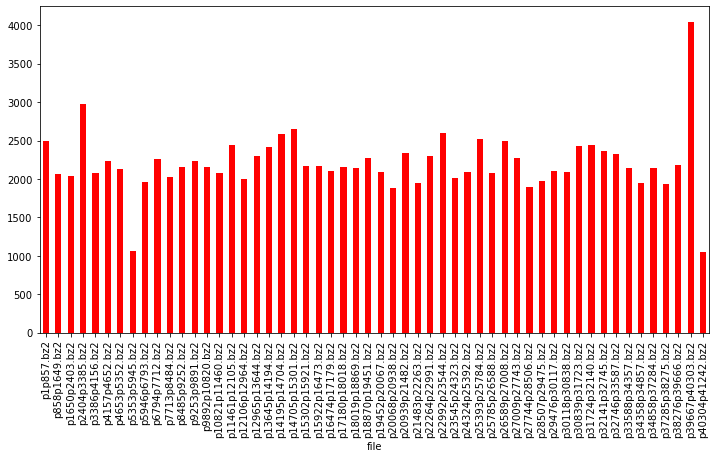

In [26]:
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

These files are then used to continue working on the project.    
For the sake of simplicity, only the first dump file `p1p857.bz2` will be used for the next steps. 